In [1]:
import numpy as np
from scipy.linalg import toeplitz
import cvxpy as cp

In this work, I try to implement the calculation of from Prof. Gustafsson and al. - "Tutorial on antenna current optimization using MATLAB and CVX", section 7. A thin strip dipole with dimensions $x$, $y$ divided into $Nx = 16$ rectangular mesh elements.

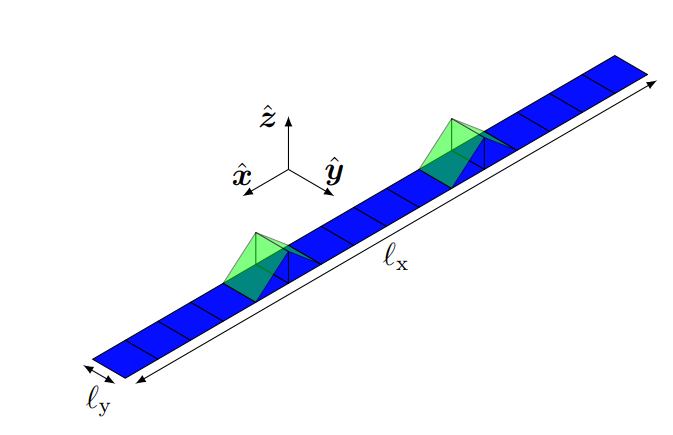

### Parametrers

In [2]:
eta0 = 299792458 * 4e-7*np.pi # free space impedance
kl = 0.48 * 2*np.pi # wavenumber,0.48lambda
Nx = 16 # number of elements
N = Nx - 1 # number of unknowns
dx = 1/Nx # rectangle length
dy = 0.02 # rectangle width

### E−energy

In [3]:
Xe11 = 1e3*np.array([1.14,-0.4485,-0.0926,-0.0153,-0.0059,-0.0030,-0.0018,-0.0013,-0.0009,-0.0008,-0.0007,-0.0006,-0.0005,-0.0005,-0.0004])
Xe = toeplitz(Xe11) 

### M−energy

In [4]:
Xm11 = 10*np.array([1.8230,0.8708,0.2922,0.1664,0.1060,0.0680,0.0411,0.0208,0.0050,-0.0074,-0.0171,-0.0244,-0.0297,-0.0332,-0.0351])
Xm = toeplitz(Xm11) # M−energy

### Radiated energy

In [5]:
Rr11 = 0.1*np.array([7.0919,7.0668,6.9918,6.8680,6.6974,6.4824,6.2264,5.9331,5.6067,5.2521,4.8744,4.4788,4.0707,3.6558,3.2393])
Rr = toeplitz(Rr11)+np.eye(N, dtype=float)*2e-5

### Far field

In [6]:
F = eta0*(-1j*kl)/4/np.pi*np.ones([1,N])*dx 

## CVX optim

In [7]:
# Define and solve the CVXPY problem.
w = cp.Variable(1)
I = cp.Variable(N)
prob = cp.Problem(cp.Minimize(w),
                 [cp.quad_form(I, Xe) <= w,
                  cp.quad_form(I, Xm) <= w,
                 F @ I == -1j])
prob.solve()

0.1047036101952615

In [8]:
# Print result.
print("\nThe optimal value is", prob.value)
print("A solution w is")
print(w.value)
print("A solution I is")
print(I.value)
print("A dual solution corresponding to the inequality constraints is")
print(prob.constraints[0].dual_value)


The optimal value is 0.1047036101952615
A solution w is
[0.10470361]
A solution I is
[0.00544208 0.00852805 0.01085947 0.01256558 0.01378651 0.01460581
 0.01507736 0.01523154 0.01507736 0.01460581 0.01378651 0.01256558
 0.01085947 0.00852805 0.00544208]
A dual solution corresponding to the inequality constraints is
[0.48755244]


## Antenna parameters from the max. 

### G/Q problem

In [9]:
P = np.abs(F@I.value)*np.abs(F@I.value)/2/eta0 # radiation intensity
Pr = np.real(I.value.T@Rr@I.value)/2 # radiated power
D = 4*np.pi*P/Pr # res. directivity
We = np.real(I.value.T@Xe@I.value)/4/kl # stored E energy
Wm = np.real(I.value.T@Xm@I.value)/4/kl # stored M energy
W = max(We,Wm) # stored energy
Q = 2*kl*W/Pr  # Q
Qe = 2*kl*We/Pr # Q electric
Qm = 2*kl*Wm/Pr # Q magnetic

Results of the optimization

In [10]:
print("Directivity:")
print(D)
print("Quality Factor:")
print(Q)
print("QF electric:")
print(Qe)
print("QF magnetic:")
print(Qm)

Directivity:
[1.6529984]
Quality Factor:
5.1886597042864775
QF electric:
5.1886597042864775
QF magnetic:
5.1886505350279295
